In [1]:
import sys
import numpy as np
import copy
%matplotlib nbagg
import matplotlib.pyplot as plt

pulse_building_folder = '/Users/Natalie/Documents/PhD/Qdev/PulseBuilding'
if pulse_building_folder not in sys.path:
    sys.path.insert(0, pulse_building_folder)

from pulse_building import Waveform, Element, Sequence

### General Variables

In [12]:
cycle_duration = 10e-6
sampling_rate = 1.2e9
resolution = 1 / sampling_rate
pulse_end = 5e-6
marker_time = 10e-9

total_points = round(cycle_duration / resolution)
pulse_end_points = round(pulse_end / resolution)
marker_points = round(marker_time / resolution)

### Readout Settings

In [13]:
pulse_readout_delay = 50e-9
readout_start = pulse_end + pulse_readout_delay
readout_time = 4e-6
pushed_resonator_freqs = [7.1235e9, 7.1794e9, 7.2111e9, 7.251e9, 7.2885e9, 7.3301e9]
carrier = 7.1e9

readout_start_points = round(readout_start / resolution)
readout_points = round(readout_time / resolution)

## Readout SSB

In [14]:
readout_ssb_sequence = Sequence(name='readout_ssb',
                       variable='ssb up from carrier')

readout_element = Element()

readout_i = Waveform(length=total_points, channel=1)
readout_q = Waveform(length=total_points, channel=2)
readout_i.marker_1[pulse_end_points:pulse_end_points + marker_points] = 1
readout_i.marker_2[pulse_end_points:pulse_end_points + marker_points] = 1

readout_time_array = np.arange(readout_points) * resolution

for freq in pushed_resonator_freqs:
    angle = readout_time_array * freq * 2 * np.pi
    cos_array = np.cos(angle) / len(pushed_resonator_freqs)
    sin_array = np.sin(angle) / len(pushed_resonator_freqs)
    readout_start = readout_start_points
    readout_end = readout_start_points + readout_points
    readout_i.wave[readout_start:readout_end] += cos_array
    readout_q.wave[readout_start:readout_end] -= sin_array

readout_element.add_waveform(readout_i)
readout_element.add_waveform(readout_q)

readout_ssb_sequence.add_element(readout_element)

readout_ssb_sequence.check()

sequence check passed: 1 elements


True

## Plot Sequence

<IPython.core.display.Javascript object>


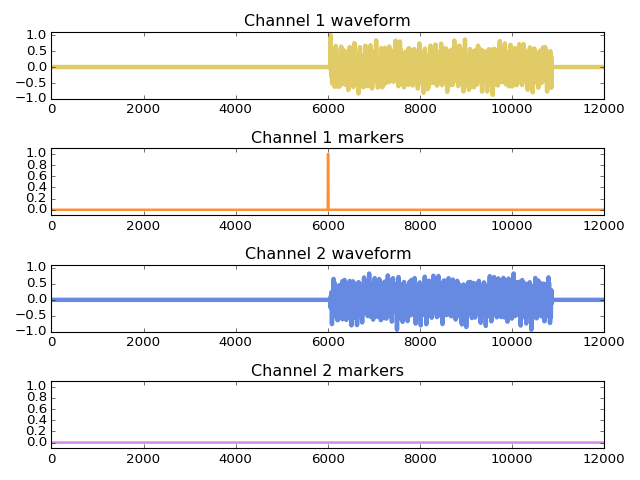

In [15]:
sequence = readout_ssb_sequence # choose which sequence to plot
elemnum = 0 # choose which element to plot
chan_a, chan_b  = 1, 2 # choose which two channels to plot

fig = plt.figure()

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.set_title('Channel {} waveform'.format(chan_a))
ax1.set_ylim([-1, 1.1])
ax2.set_title('Channel {} markers'.format(chan_a))
ax2.set_ylim([-0.1, 1.1])
ax3.set_title('Channel {} waveform'.format(chan_b))
ax3.set_ylim([-1, 1.1])
ax4.set_title('Channel {} markers'.format(chan_b))
ax4.set_ylim([-0.1, 1.1])


ax1.plot(sequence[elemnum][chan_a].wave, lw=4, color='#e1cb66')
ax2.plot(sequence[elemnum][chan_a].marker_1, lw=2, color='#FF4500', alpha=0.6)
ax2.plot(sequence[elemnum][chan_a].marker_2, lw=2, color='#FF8C00', alpha=0.6)

ax3.plot(sequence[elemnum][chan_b].wave, lw=4, color='#6689e1')
ax4.plot(sequence[elemnum][chan_b].marker_1, lw=2, color='#6A5ACD', alpha=0.6)
ax4.plot(sequence[elemnum][chan_b].marker_2, lw=2, color='#EE82EE', alpha=0.6)

plt.tight_layout()

## Upload to AWG

In [90]:
(waveforms, m1s, m2s ,nreps, trig_waits, goto_states, jump_tos) = ssb_sequence.unwrap()

In [7]:
import qcodes.instrument_drivers.tektronix.AWG5014 as awg
awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.170::inst0::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5014C (serial:B010169, firmware:SCPI:99.0 FW:4.2.0.27) in 0.21s


In [91]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s, 
                                 nreps, trig_waits,
                                 goto_states, jump_tos)

In [92]:
awg1.ch1_state(1)
awg1.ch2_state(1)
awg1.ch3_state(1)
awg1.run()

'Running'